In [37]:
import re
import ast
import pickle
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from utils_martina.my_utils import *

In [38]:
logs_path = "..\\..\\explainability\GRETEL-repo\\output\\logs\\"
eval_manager_path = "..\\..\\explainability\GRETEL-repo\\output\\eval_manager\\"
output_path = "..\\..\\explainability\GRETEL-repo\\output\\metrics\\"

In [39]:
file_name = get_most_recent_file(eval_manager_path).split('.')[0]
print(file_name)

26040-Martina


## Info

In [40]:
index_evaluator = 0

In [ ]:
# Set patient and record

# ["chb01_03", "chb01_04", "chb01_15", "chb01_16", "chb01_18", "chb01_21", "chb01_26"]

patient_id = "chb01"
record_id = "03"

# No penalizzazione temporale
# file_name = 16688-Martina

# Penalizzazione temporale
# file_name = 26040-Martina

In [42]:
if patient_id[:2] == "PN":      # Frequency Siena dataset
    frequency = 512
elif patient_id[:3] == "chb":   # Frequency CHB-MIT dataset
    frequency = 256

## Load data

In [43]:
# Load information related to the EEG of patient_id, record_id
with open(f"EEG_data\EEG_data_params_{patient_id}_{record_id}.pkl", "rb") as f:
    loaded_variables = pickle.load(f)

indices = loaded_variables["indici"]
Start = loaded_variables["Start"]
End = loaded_variables["End"]
seizure_starts = loaded_variables["seizure_starts"]
seizure_ends = loaded_variables["seizure_ends"]
seizure_class = loaded_variables["seizure_class"]

In [44]:
# Load logs
with open(logs_path + file_name + '.info', "r") as file:
    content = file.read()

# Load eval_manager
with open(eval_manager_path + file_name + '.pkl', 'rb') as f:
    eval_manager = pickle.load(f)

In [45]:
for i in range(len(eval_manager._evaluators)):
    if i == index_evaluator:
        print(f"---> {eval_manager._evaluators[i]._explainer.name}")
    else:
        print(f"     {eval_manager._evaluators[i]._explainer.name}")

---> DCESExplainer-3cbc0ed5617a269c1a6b2336dbadae85


### Oracle and explainer metrics

In [46]:
# Creating a dictionary for each metric
RuntimeMetric = extract_dictionary_from_runtime_metric(content,"RuntimeMetric",i=index_evaluator)
GraphEditDistanceMetric = extract_dictionary_from_runtime_metric(content,"GraphEditDistanceMetric",i=index_evaluator + 1)
OracleCallsMetric = extract_dictionary_from_runtime_metric(content,"OracleCallsMetric",i=index_evaluator)
CorrectnessMetric = extract_dictionary_from_runtime_metric(content,"CorrectnessMetric",i=index_evaluator)
SparsityMetric = extract_dictionary_from_runtime_metric(content,"SparsityMetric",i=index_evaluator)
FidelityMetric = extract_dictionary_from_runtime_metric(content,"FidelityMetric",i=index_evaluator)
OracleAccuracyMetric = extract_dictionary_from_runtime_metric(content,"OracleAccuracyMetric",i=index_evaluator)
EmbeddingMetric = extract_dictionary_from_runtime_metric(content,"EmbeddingMetric",i=index_evaluator)

# Extraction of times and records
dict_time, dict_record = extract_time_and_record(content,i=index_evaluator)

In [47]:
# Extracting data of desired record
RuntimeMetric = {id: value for id, value in RuntimeMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
GraphEditDistanceMetric = {id: value for id, value in GraphEditDistanceMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
OracleCallsMetric = {id: value for id, value in OracleCallsMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
CorrectnessMetric = {id: value for id, value in CorrectnessMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
SparsityMetric = {id: value for id, value in SparsityMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
FidelityMetric = {id: value for id, value in FidelityMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
OracleAccuracyMetric = {id: value for id, value in OracleAccuracyMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}
EmbeddingMetric = {id: value for id, value in EmbeddingMetric.items() if dict_record[id] == f"{patient_id}_{record_id}"}

In [48]:
# Extracting other metrics
graph_metrics = get_other_info(content, 'graph_metrics',i=index_evaluator)
graph_metrics = [entry for entry in graph_metrics if dict_record[str(entry['instance_id'])] == f"{patient_id}_{record_id}"]

In [49]:
# Calculation of time instants associated with the graphs
id_graphs = [id for id, value in dict_record.items() if value == f"{patient_id}_{record_id}"]
time_graphs = [dict_time[id] for id in id_graphs]

indices_test = []
times_test = []

for id in time_graphs:
    indices_test.append(indices[id])
    times_test.append(indices[id]/frequency + Start)

In [50]:
# Function to plot vertical bands for seizure conditions
def add_seizure_shading(ax, starts, ends, also_horizontal=False):
    for start, end in zip(starts, ends):
        ax.axvspan(start, end, color='yellow', alpha=0.5)

        if also_horizontal:
            ax.axhspan(start, end, color='orange', alpha=0.5)

In [51]:
def get_number_edges(evaluator):
    result = []

    for g1, g2 in evaluator.get_instance_explanation_pairs():
        # Create graphs from adjacency matrices
        G_orig = nx.from_numpy_array(g1.data)

        # Difference between adjacency matrices
        A_diff = g1.data - g2.data
        edges_added = nx.from_numpy_array(A_diff == -1)
        edges_removed = nx.from_numpy_array(A_diff == 1)

        result.append({ 'id': g1.id, 'patient_record': f"{g1.patient_id}_{g1.record_id}", 'original': G_orig.number_of_edges(), 'added': edges_added.number_of_edges(), 'removed': edges_removed.number_of_edges() })
    
    return result

a = get_number_edges(eval_manager._evaluators[index_evaluator])
a = [entry for entry in a if entry['patient_record'] == f"{patient_id}_{record_id}"]

original = [entry['original'] for entry in a]
added = [entry['added'] for entry in a]
removed = [entry['removed'] for entry in a]

# Number of modified edges
modified_edges = [r + a for r, a in zip(removed, added)]

with open(f"{output_path}data_edges\\{file_name.split('-')[0]}-{patient_id}_{record_id}_{(eval_manager._evaluators[index_evaluator]._explainer.name).split('-')[0]}.pkl", 'wb') as f:
    pickle.dump({'times_test': times_test, 'modified_edges': modified_edges}, f)

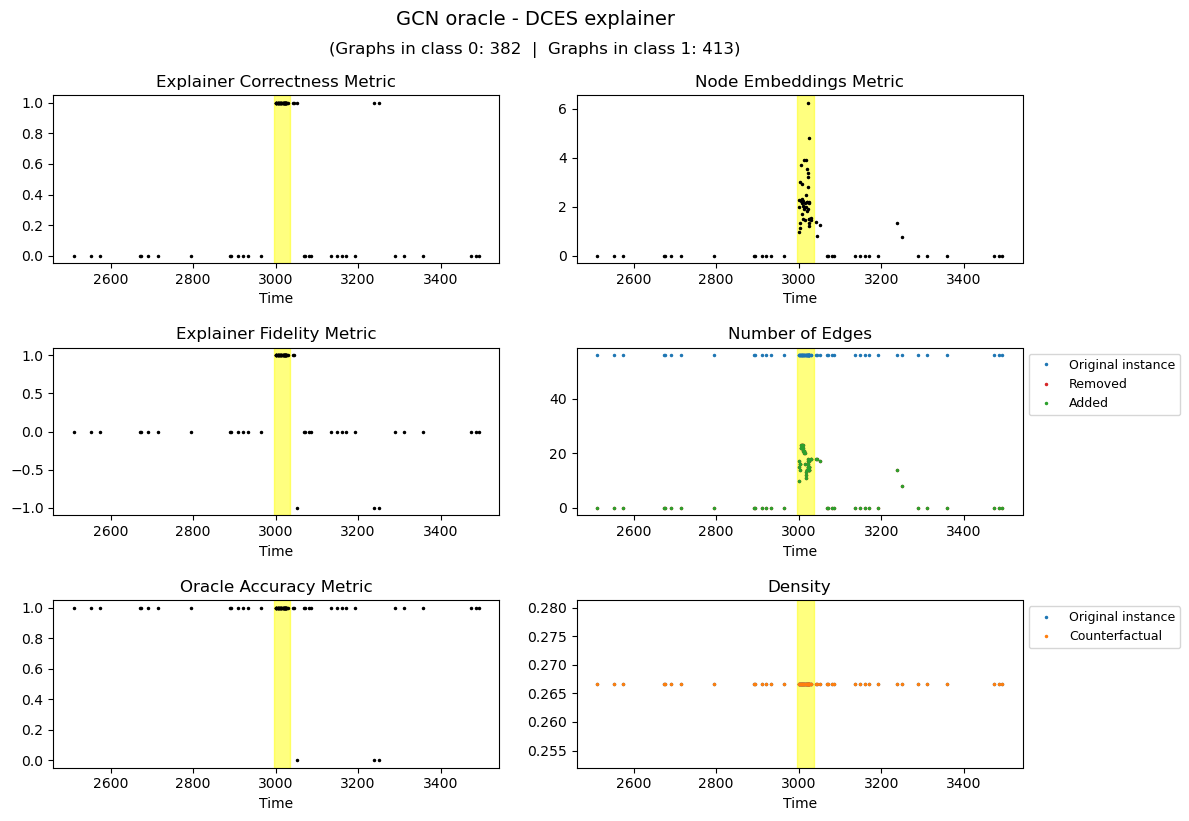

In [52]:
fig, axes = plt.subplots(3, 2, figsize=(12,8), gridspec_kw={'width_ratios': [1, 1]})

# Subplot 1: Correctness Metric
add_seizure_shading(axes[0,0], seizure_starts, seizure_ends)
axes[0,0].plot(times_test, np.array(list(CorrectnessMetric.values())), label='Correctness', marker='.', linestyle='', markersize=3, color='black')
axes[0,0].set_title('Explainer Correctness Metric')

# Subplot 2: Fidelity Metric
add_seizure_shading(axes[1,0], seizure_starts, seizure_ends)
axes[1,0].plot(times_test, np.array(list(FidelityMetric.values())), label='Fidelity', marker='.', linestyle='', markersize=3, color='black')
axes[1,0].set_title('Explainer Fidelity Metric')

# Subplot 3: Oracle Accuracy Metric
add_seizure_shading(axes[2,0], seizure_starts, seizure_ends)
axes[2,0].plot(times_test, np.array(list(OracleAccuracyMetric.values())), label='Oracle Accuracy', marker='.', linestyle='', markersize=3, color='black')
axes[2,0].set_title('Oracle Accuracy Metric')

# Subplot 4: Node Embeddings Metric
add_seizure_shading(axes[0,1], seizure_starts, seizure_ends)
axes[0,1].plot(times_test, np.array(list(EmbeddingMetric.values())), label='Node Embeddings Metric', marker='.', linestyle='', markersize=3, color='black')
axes[0,1].set_title('Node Embeddings Metric')

# Subplot 5: Graph Edit Distance Metric
# add_seizure_shading(axes[1,1], seizure_starts, seizure_ends)
# axes[1,1].plot(times_test, np.array(list(GraphEditDistanceMetric.values())), label='Graph Edit Distance Metric', marker='.', linestyle='', markersize=3, color='black')
# axes[1,1].set_title('Graph Edit Distance Metric')

# Subplot 5: Number of Edges
ax_edges = axes[1,1]
ax_edges.plot(times_test, original, label='Original instance', marker='.', linestyle='', markersize=3, color='tab:blue')
ax_edges.plot(times_test, removed, label='Removed', marker='.', linestyle='', markersize=3, color='tab:red')
ax_edges.plot(times_test, added, label='Added', marker='.', linestyle='', markersize=3, color='tab:green')
add_seizure_shading(ax_edges, seizure_starts, seizure_ends)
ax_edges.set_title('Number of Edges')
ax_edges.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)

# Subplot 6: Density
ax_density = axes[2,1]
add_seizure_shading(ax_density, seizure_starts, seizure_ends)
ax_density.plot(times_test, np.array([entry['density_instance'] for entry in graph_metrics]), label='Original instance', marker='.', linestyle='', markersize=3) #, color='yellowgreen')
ax_density.plot(times_test, np.array([entry['density_counterfactual'] for entry in graph_metrics]), label='Counterfactual', marker='.', linestyle='', markersize=3) #, color='olivedrab')
ax_density.set_title('Density')
ax_density.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=9)

# General settings
for ax in axes.flatten():
    ax.set_xlabel('Time')
    # ax.set_ylabel('Metric Value')
    # ax.set_xlim((Start,End))

fig.suptitle(get_oracle_and_explainer_names(eval_manager,index_evaluator), fontsize=14, x=0.45, y=1.02)
text = f"(Graphs in class 0: {seizure_class.count(0)}  |  Graphs in class 1: {seizure_class.count(1)})"
fig.text(0.45, 0.965, text, fontsize=12, ha='center')

plt.tight_layout(h_pad=1.5, w_pad=2)
plt.savefig(f"{output_path}{file_name.split('-')[0]}-{patient_id}_{record_id}_{(eval_manager._evaluators[index_evaluator]._explainer.name).split('-')[0]}.png", dpi=300)
plt.show()

### Confronto id_istanza e id_controfattuale (per il momento non è possibile se ci sono più pazienti)

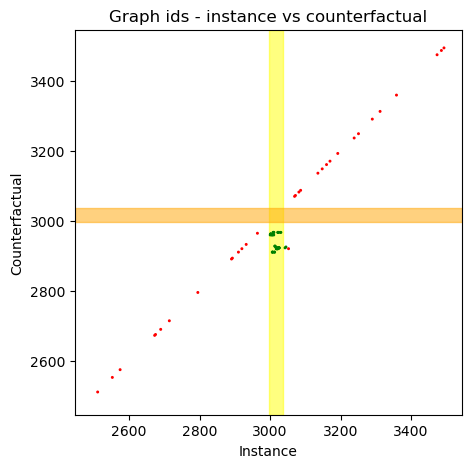

In [53]:
# Calcolo degli istanti temporali associati ai grafi
id_instance = []
id_counterfactual = []
correct = []

for i in range(len(eval_manager._evaluators[0].get_instance_explanation_pairs())):
    g1, g2 = eval_manager._evaluators[0].get_instance_explanation_pairs()[i]
    
    if g1.patient_id == patient_id and g1.record_id == record_id:
        id_instance.append(g1.time)
        id_counterfactual.append(g2.time)

        correct.append(g1.label != g2.label)

t_instance = []
t_counterfactual = []

for id in id_instance:
    t_instance.append(indices[id]/256 + Start)

for id in id_counterfactual:
    t_counterfactual.append(indices[id]/256 + Start)

colors = ['green' if c else 'red' for c in correct]

# Figura
fig, ax = plt.subplots(figsize=(5,5))
add_seizure_shading(ax, seizure_starts, seizure_ends, also_horizontal=True)
ax.scatter(np.array(t_instance), np.array(t_counterfactual), marker='.', color=colors, s=5)
ax.set_title('Graph ids - instance vs counterfactual')
ax.set_xlim([Start-50,End+50])
ax.set_ylim([Start-50,End+50])
# ax.set_xlim([seizure_starts[0]-5,seizure_ends[-1]+5])
# ax.set_ylim([Start-50,End+50])
ax.set_xlabel('Instance')
ax.set_ylabel('Counterfactual')

# # Linee oracolo (per il momento non è possibile se ci sono più pazienti)
# all_embeddings = get_embeddings_and_outputs_all(eval_manager,0)

# for i in range(len(all_embeddings)):
#     if all_embeddings[i]['data_instance_label'] != all_embeddings[i]['prediction']: 
#         ax.axvline(x=indices[i]/frequency + Start, color='red', linestyle=':', linewidth=1, alpha=0.3)
#         ax.axhline(y=indices[i]/frequency + Start, color='red', linestyle=':', linewidth=1, alpha=0.3)

plt.show()

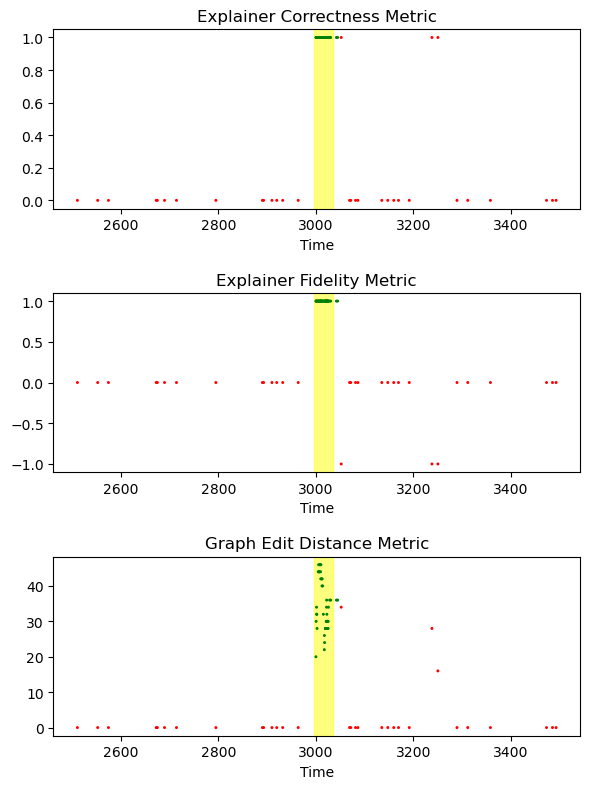

In [54]:
fig, axes = plt.subplots(3, 1, figsize=(6,8))

# Subplot 1: Correctness Metric
add_seizure_shading(axes[0], seizure_starts, seizure_ends)
axes[0].scatter(times_test, np.array(list(CorrectnessMetric.values())), label='Correctness', marker='.', s=5, color=colors)
axes[0].set_title('Explainer Correctness Metric')

# Subplot 2: Fidelity Metric
add_seizure_shading(axes[1], seizure_starts, seizure_ends)
axes[1].scatter(times_test, np.array(list(FidelityMetric.values())), label='Fidelity', marker='.', s=5, color=colors)
axes[1].set_title('Explainer Fidelity Metric')

# Subplot 5: Graph Edit Distance Metric
add_seizure_shading(axes[2], seizure_starts, seizure_ends)
axes[2].scatter(times_test, np.array(list(GraphEditDistanceMetric.values())), label='Graph Edit Distance Metric', marker='.', s=5, color=colors)
axes[2].set_title('Graph Edit Distance Metric')

# General settings
for ax in axes.flatten():
    ax.set_xlabel('Time')

plt.tight_layout(h_pad=1.5, w_pad=2)
plt.show()